# Self Organized Maps Hybrid (Unsupervized to Supervized)

### SOM Part

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#
dataset = pd.read_csv("data/SOM/Credit_Card_Applications.csv")
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
#
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) # skala 0-1 arasında olacak
X = sc.fit_transform(X)
#
from data.SOM.minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(X, num_iteration = 100)

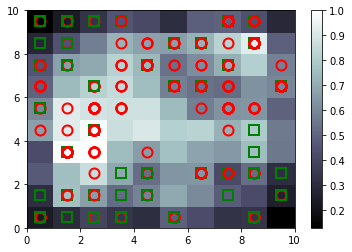

In [13]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5, w[1] + 0.5, markers[y[i]], 
         markeredgecolor = colors[y[i]], markerfacecolor = 'None', markersize = 10, markeredgewidth = 2) 
show()

In [16]:
mappings = som.win_map(X)
frauds = mappings[(6, 1)] + mappings[(6, 2)]
frauds = sc.inverse_transform(frauds)
print(len(frauds))

21


### ANN Part

In [21]:
# matrix of features
customers = dataset.iloc[:, 1:].values # müşteri id hariç hepsini alıyoruz
# dependent variable (y)
is_fraud = np.zeros(len(dataset)) # bütün sütun değerleri sıfır olan bir liste oluşturuyoruz
# bu listede frauds olan müşteri indexlerini 1 yapıyoruz ki dolandırıcı olduklarını temsil etsin
is_fraud = [1 if dataset.iloc[i, 0] in frauds else 0 for i in range(len(is_fraud))]
print(sum(is_fraud))

21


In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)
#
from keras.models import Sequential # ağı initilize etmek için gerekli
from keras.layers import Dense # katmanlar için gerekli

classifier = Sequential()
classifier.add(Dense(activation = "relu", input_dim = 15, units = 2, kernel_initializer = "uniform"))
classifier.add(Dense(activation = "sigmoid", units = 1, kernel_initializer = "uniform"))
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
classifier.fit(customers, is_fraud, batch_size = 1, epochs = 2)
# veri seti çok basit olduğu için çok basit bir ann kuruyoruz, featureler arasındaki ilişkiyi çözmesi zor değil
# nasılsa az verimiz var yani

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/2
690/690 [==============================] - 1s 1ms/step - loss: 0.4539 - acc: 0.9696
Epoch 2/2
690/690 [==============================] - 0s 641us/step - loss: 0.1728 - acc: 0.9696


In [23]:
y_pred = classifier.predict(customers)
# iloc ile bir sütun seçip 2 boyutlu bir dizi yaratmak için 0 yerine 0:1 yazıyoruz
# müşteri idleri ile çıkan sonuçlarıyla liste oluşturuyoruz
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
# sort customers by their probability of cheating
y_pred = y_pred[y_pred[:, 1].argsort()]